
# Autoencoder Reconstruction Error를 이용한 Fraud Detection

- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 `Time` 과 `Amount`입니다.`'Time` 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. `Amount` 특성은 거래금액 입니다.



- `Class`는 사기의 경우 1, 그렇지 않으면 0 입니다.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

## Downloading of dataset

In [3]:
df = pd.read_csv( 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- the dataset is highly unbalanced

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
fraud = (df['Class'] == 1).sum()
normal = (df['Class'] == 0).sum()

total = fraud + normal

print(f"Total = {total:,}")
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


- Time 필드를 일중 시간으로 변환합니다.   
- Amount 필드는 로그 스케일로 변환합니다.

In [6]:
df.loc[:, "Time"]   = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) #24 시간
df.loc[:, 'Amount'] = np.log(df.loc[:, 'Amount'] + 1)

- class 1 이 너무 적으므로 통상적인 7:3 대신 5:5 비율로 train, test set 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                        df.drop('Class', axis=1), df['Class'],
                        test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test  = sc.transform(X_test.values)

In [9]:
y_train.value_counts() / y_train.count()

0    0.998251
1    0.001749
Name: Class, dtype: float64

In [10]:
y_test.value_counts() / y_test.count()

0    0.998294
1    0.001706
Name: Class, dtype: float64

## Autoencoder Train

- 정상 거래로만 오토 인코더를 교육합니다.   

- 사기성(비정상) 거래의 재구성 error 가 비사기성 거래보다 높을 것으로 기대합니다.

In [13]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

X_train_normal.shape, X_train_fraud.shape

((142154, 30), (249, 30))

In [14]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]

X_test_normal.shape, X_test_fraud.shape

((142161, 30), (243, 30))

## DNN model 작성
- 정상 데이터만 사용하여 훈련

In [15]:
input_layer = Input(shape=(30, ))
encoded_normal = Dense(12, activation='relu')(input_layer)
decoded_normal = Dense(30, activation='linear')(encoded_normal)

autoencoder_normal = Model(input_layer, decoded_normal)
autoencoder_normal.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 12)                372       
                                                                 
 dense_1 (Dense)             (None, 30)                390       
                                                                 
Total params: 762 (2.98 KB)
Trainable params: 762 (2.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
autoencoder_normal.compile(optimizer='adam', loss='mse')

### 정상 data로 만 train  

In [17]:
history = autoencoder_normal.fit(X_train_normal, X_train_normal,
                                 epochs = 30, batch_size=128,
                            validation_data=(X_test_normal, X_test_normal))

Epoch 1/30
1111/1111 [==============================] - 10s 4ms/step - loss: 0.7455 - val_loss: 0.5865
Epoch 2/30
1111/1111 [==============================] - 4s 4ms/step - loss: 0.5563 - val_loss: 0.5339
Epoch 3/30
1111/1111 [==============================] - 4s 4ms/step - loss: 0.5308 - val_loss: 0.5265
Epoch 4/30
1111/1111 [==============================] - 4s 4ms/step - loss: 0.5267 - val_loss: 0.5245
Epoch 5/30
1111/1111 [==============================] - 4s 3ms/step - loss: 0.5253 - val_loss: 0.5240
Epoch 6/30
1111/1111 [==============================] - 4s 3ms/step - loss: 0.5243 - val_loss: 0.5233
Epoch 7/30
1111/1111 [==============================] - 4s 3ms/step - loss: 0.5237 - val_loss: 0.5247
Epoch 8/30
1111/1111 [==============================] - 4s 3ms/step - loss: 0.5232 - val_loss: 0.5231
Epoch 9/30
1111/1111 [==============================] - 4s 4ms/step - loss: 0.5227 - val_loss: 0.5233
Epoch 10/30
1111/1111 [==============================] - 4s 4ms/step - loss: 0.52

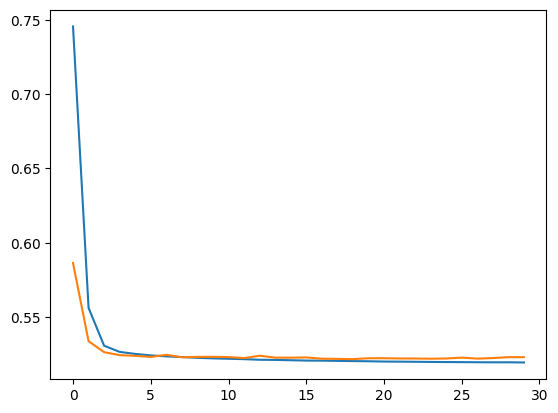

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Reconstruction Error 시각화

- Anomaly data 와의 bar chart 비교를 위해 정상 abnormal data 갯수 만큼의 임의의 normal sample 을 선택

In [19]:
indices = np.random.choice(len(X_train_normal), 250, replace=False)
Nom_data = X_train_normal[indices]
Nom_data.shape

(250, 30)

### 정상 data 및 fraud data 의 autoencoder 재 구성값
- 정상 data의 metric

In [20]:
 # AE 결과값
Nom_pred = autoencoder_normal.predict(Nom_data, verbose=0)
# input - output 간의 MSE 구하기
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1)

print('정상 데이터의 Metric')
#계산한 MSE 값을 'Normal_mse'라는 열 이름으로 가진 DataFrame을 생성
Nom_pred_mse_df = pd.DataFrame({'Normal_mse': Nom_pred_mse})
#생성한 DataFrame에 대한 기초 통계량(평균, 표준편차, 최소값, 최대값, 백분위수 등)을 계산
Nom_pred_mse_df.describe()

정상 데이터의 Metric


,Normal_mse
count,250.000000
mean,0.497511
std,1.187822
min,0.082149
25%,0.199744
50%,0.292900
75%,0.476798
max,15.566993


- fraud data의 metric

In [21]:
# AE 결과값
ANom_pred = autoencoder_normal.predict(X_train_fraud, verbose=0)
# input - output 간의 MSE 구하기
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1)
print('Fraud 데이터의 Metric')
#계산한 MSE 값을 'Anomaly_mse'라는 열 이름으로 가진 DataFrame을 생성
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse': ANom_pred_mse})
#생성한 DataFrame에 대한 기초 통계량(평균, 표준편차, 최소값, 최대값, 백분위수 등)을 계산
ANom_pred_mse_df.describe()

Fraud 데이터의 Metric


,Anomaly_mse
count,249.000000
mean,23.302396
std,30.339145
min,0.172630
25%,4.170097
50%,9.120728
75%,26.428503
max,188.176915


### 정상 data 와 anomaly data 간의 MSE 차이 시각화

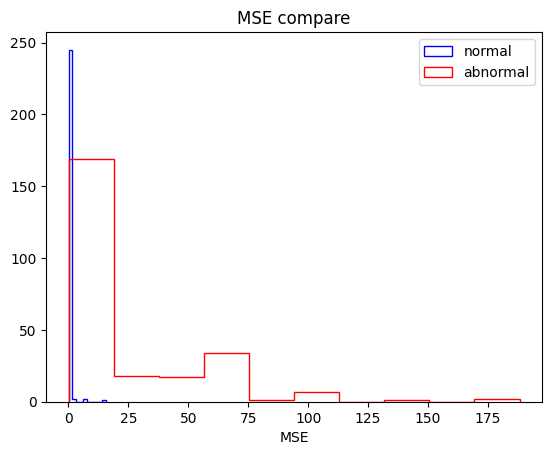

In [22]:
plt.title('MSE compare')
#정상 데이터의 MSE 값들을 10개의 구간(bins)으로 나누어 히스토그램을 그립니다.
#히스토그램의 색상은 'blue'로 설정하고, 히스토그램의 형태는 'step'으로 설정
plt.hist(Nom_pred_mse, bins=10, color='blue', histtype='step', label='normal')
#이상치 데이터의 MSE 값들을 10개의 구간(bins)으로 나누어 히스토그램을 그립니다.
#히스토그램의 색상은 'red'로 설정하고, 히스토그램의 형태는 'step'으로 설정
plt.hist(ANom_pred_mse, bins=10, color='red', histtype='step', label='abnormal')
plt.xlabel('MSE')
plt.legend()
plt.show()

### 정상, 비정상 data 의 box plot 비교  
- 정상 데이터와 이상치 데이터의 MSE 값들을 박스 플롯으로 그립니다. 박스 플롯은 데이터의 중앙값(median), 사분위수(quartiles), 이상치(outliers) 등을 한눈에 볼 수 있게 해주는 시각화 도구입니다.

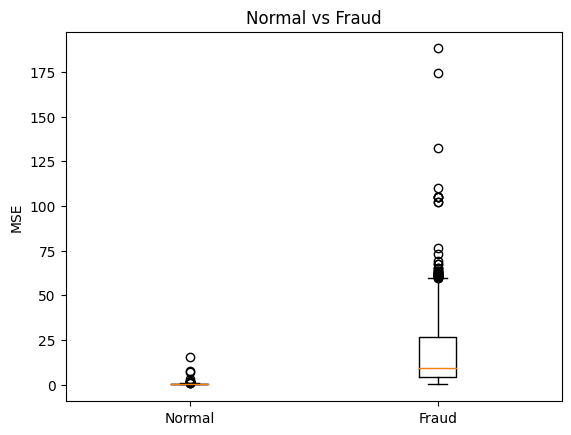

In [23]:
plt.boxplot([Nom_pred_mse, ANom_pred_mse])
plt.title('Normal vs Fraud')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Fraud'])
plt.ylabel('MSE')
plt.show()

## Reconstruction error threshold 결정

- 정상 data 로만 train 한 vae model 의 재구성 결과의 원본과의 mse 차이를 기준으로 사기 거래 분류

In [26]:
# 정상 데이터를 원본으로 autoencoder를 통과시켜 복원
predictions = autoencoder_normal.predict(X_train)
# 정상데이터의 복원 오차 MSE 계산
mse = np.mean(np.power(X_train - predictions, 2), axis=1) #행 방향으로 연산

#계산한 MSE를 'reconstruction_error',
#원본 데이터의 레이블을 'true_class'라는 열 이름으로 가진 DataFrame을 생성
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})
error_df.head()

4451/4451 [==============================] - 6s 1ms/step


,reconstruction_error,true_class
269414,1.310868,0
75463,0.136645,0
99307,0.073495,0
212267,0.736374,0
157412,0.371158,0


In [28]:
# 'error_df' 데이터프레임을 'true_class' 열에 따라 그룹화 후 기술통계 출력
desc = error_df.groupby('true_class').describe()
desc

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      142154.0   0.519296   1.933284  0.032577  0.204582   
1                         249.0  23.302396  30.339145  0.172630  4.170097   

                                             
                 50%        75%         max  
true_class                                   
0           0.301589   0.482905  185.524215  
1           9.120728  26.428503  188.176915

- 위에서 볼 수 있듯이 사기성이 아닌 경우의 오류는 사기성 사례의 오류보다 낮습니다.   


- mean + 3 * std 를 threshold 로 사용하여 test set 의 재구성 error (squared error) 가 threshold 보다 크면 fraud 거래로 분류합니다.  

- 1 std - 68%, 2 std - 96%, 3std - 99.8%   


- 이 방법은 3-sigma 규칙(또는 z-score)을 이용한 이상치 탐지 기법을 구현한 것입니다. 3-sigma 규칙은 정규 분포에서 평균에서 표준편차의 3배 이상 떨어진 값은 이상치로 간주하는 규칙입니다. 이 규칙에 따르면, 평균에서 표준편차의 3배 이상 떨어진 데이터는 전체 데이터의 약 0.2%에 불과합니다. 이 방법은 데이터가 정규 분포를 따르는 경우에 효과적이지만, 그렇지 않은 경우에는 다른 이상치 탐지 방법을 고려해야 할 수 있습니다.

In [30]:
# 'desc' 데이터프레임에서 'reconstruction_error' 열의 평균(mean)과 표준편차(std)를 추출합니다.
# 이 값들은 true_class가 0인 그룹에 대한 값입니다.
mean = desc['reconstruction_error']['mean'][0]
std = desc['reconstruction_error']['std'][0]

# 평균과 표준편차를 사용하여 다양한 임계값(thresholds)을 설정합니다.
# 이 임계값들은 이상치 탐지에 사용될 수 있습니다.
thresholds = {"3sigma": mean + 3*std, "2.5sigma": mean + 2.5*std, "2sigma": mean + 2*std}

print(f"재구성 오류 평균값 = {mean:.3}")
print(f"재구성 오류 표준편차 = {std:.3}")
print(f"임계값 = {thresholds}")

재구성 오류 평균값 = 0.519
재구성 오류 표준편차 = 1.93
임계값 = {'3sigma': 6.319146421001931, '2.5sigma': 5.352504609332238, '2sigma': 4.385862797662545}


In [31]:
#입력된 재구성 오차(er)가 '3sigma' 임계값 이상이면 1을 반환하고, 그렇지 않으면 0을 반환합니다.
#즉 임계값 이상이면 이상치로 간주하여 1을 반환하고, 임계값 미만이면 정상치로 간주하여 0을 반환
[(lambda er: 1 if er >= thresholds['3sigma']  else 0)(er) for er in [0, 5, 10, 50, 150]]

[0, 0, 1, 1, 1]

### 재구성 오류를 이용한 anomaly detection   
- 각 임계값을 기준으로 Autoencoder 모델의 예측 성능을 평가하고, 오차 행렬(confusion matrix)을 시각화

4451/4451 [==============================] - 6s 1ms/step
Precision 0.12
Recall 0.70


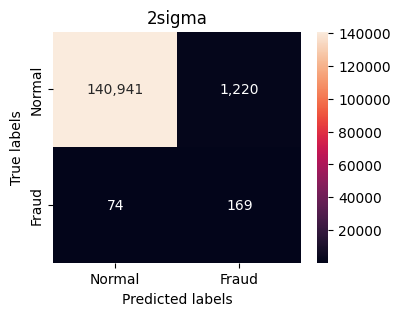

4451/4451 [==============================] - 6s 1ms/step
Precision 0.13
Recall 0.62


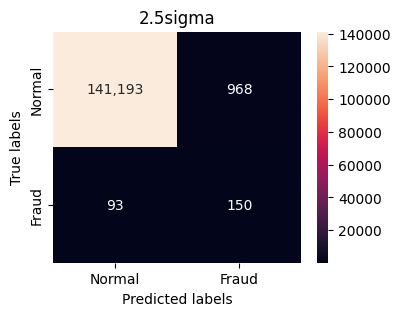

4451/4451 [==============================] - 5s 1ms/step
Precision 0.16
Recall 0.59


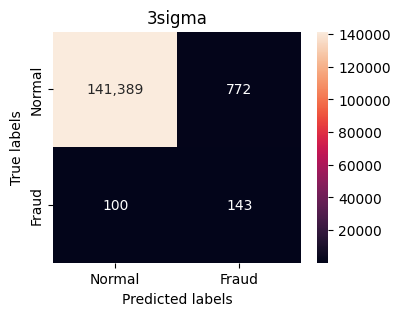

In [34]:
# thresholds dictionary를 value(임계값)에 따라 오름차순으로 정렬합니다.
ths = sorted(thresholds.items(), key=lambda kv: kv[1])

# 각 임계값에 대해 반복합니다.
for k, threshold in ths:
    # 테스트 데이터에 대해 autoencoder 모델을 사용하여 예측을 수행합니다.
    test_predictions = autoencoder_normal.predict(X_test)
    # 복원오차(MSE)를 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    # 복원오차가 임계값 이상이면 이상치(1)로, 미만이면 정상치(0)로 판단합니다.
    y_pred = [(lambda er: 1 if er >= threshold  else 0)(er) for er in mse]

    # 정밀도와 재현율을 계산하고 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬을 계산하고 시각화합니다.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud']);
    ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])
    ax.set_title(k)
    plt.show()